##### Imports

In [1]:
import sys
from pathlib import Path
import warnings

import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

import sys
# Custom library paths
sys.path.extend(['../', './scr'])

from scr.utils import set_seed
from scr.utils import read_words
from pathlib import Path
import random
from collections import Counter, defaultdict
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset

from scr.utils import read_words, save_words_to_file

import pickle
from pathlib import Path
from scr.dataset import *
from scr.utils import *
# # For inference
from scr.feature_engineering import *
from scr.encoder import *
from scr.trainer_ import *
from scr.decoder import SimpleLSTM

import gc

set_seed(42)

import torch
import torch.nn as nn
from pathlib import Path
import random

from scr.utils import print_scenarios
torch.set_float32_matmul_precision('medium')
from pathlib import Path

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Read and Shuffle Word List
word_list = read_words('data/words_250000_train.txt') # , limit=10000)
# word_list = read_words('data/250k.txt', limit=10000)

random.shuffle(word_list)

# Calculate Frequencies and Max Word Length
word_frequencies = calculate_word_frequencies(word_list)
char_frequency = calculate_char_frequencies(word_list)
max_word_length = max(len(word) for word in word_list)

##### Data Dir

In [2]:
NUM_STRATIFIED_SAMPLES = 100 # This will be overwritten by Papermill

NUM_WORD_SAMPLE = 1_00 # words for testing

FAST_DEV_RUN = False

MAX_EPOCH = 250

In [3]:
from pathlib import Path
from scr.custom_sampler import *

# Define the base directory and the paths for training and validation parquet files
base_dataset_dir = Path("/media/sayem/510B93E12554BBD1/dataset/")
stratified_samples_dir = base_dataset_dir / str(NUM_STRATIFIED_SAMPLES)
parquet_path = stratified_samples_dir / 'parquets'

# Create directories for train and validation parquets if they don't exist
parquet_path.mkdir(parents=True, exist_ok=True)
# parquet_valid_path.mkdir(parents=True, exist_ok=True)

# Define and create the directory for models
models_dir = Path("/home/sayem/Desktop/Hangman/models")
models_dir.mkdir(parents=True, exist_ok=True)

# Define your output directory
# Define your output directory and logger directory
output_dir = Path("/home/sayem/Desktop/Hangman/training_outputs")
logger_dir = output_dir / "lightning_logs"

# Create the output and logger directories if they don't exist
output_dir.mkdir(parents=True, exist_ok=True)
logger_dir.mkdir(parents=True, exist_ok=True)

# Define the file path for saving the testing words
testing_words_file_path = stratified_samples_dir / "testing_words.txt"

try:
    testing_word_list = read_words(testing_words_file_path)
    print(f"Length of the testing word list: {len(testing_word_list)}")
    sampled_test_words = stratified_sample_by_length_and_uniqueness(testing_word_list, NUM_WORD_SAMPLE)
    print(f"Sampled {len(sampled_test_words)} unique words for testing.")
except FileNotFoundError:
    print(f"File not found: {testing_words_file_path}")

print(len(sampled_test_words))

Length of the testing word list: 10048
Sampled 230 unique words for testing.
230


##### Dataset Loading and train test split

In [4]:
# Create datasets directly from the saved parquet files
hangman_dataset = HangmanDataset(parquet_path)
# valid_dataset = HangmanDataset(parquet_valid_path)

from scr.utils import *

# Split the dataset into training and validation sets
train_dataset, valid_dataset = hangman_dataset.split(test_size=0.2)

In [5]:
def check_seq_len_distribution(dataset):
    distribution = {}
    for seq_len, indices in dataset.seq_len_index.items():
        distribution[seq_len] = len(indices)
    return distribution

# Check proportions
print(f"Total samples in original dataset: {len(hangman_dataset)}")
print(f"Samples in training dataset: {len(train_dataset)}")
print(f"Samples in validation dataset: {len(valid_dataset)}")

# Verify that the sum of train and validation samples equals the total samples
assert len(train_dataset) + len(valid_dataset) == len(hangman_dataset), "Mismatch in total sample count"

# Check sequence length distribution in each dataset
train_distribution = check_seq_len_distribution(train_dataset)
valid_distribution = check_seq_len_distribution(valid_dataset)

print("Training dataset sequence length distribution:", train_distribution)
print("Validation dataset sequence length distribution:", valid_distribution)

# Ensure each sequence length is represented in both datasets
assert set(train_distribution.keys()) == set(valid_distribution.keys()), "Mismatch in sequence length representation"

Total samples in original dataset: 8658
Samples in training dataset: 6916
Samples in validation dataset: 1742
Training dataset sequence length distribution: {4: 456, 5: 412, 7: 936, 6: 344, 9: 666, 8: 852, 3: 597, 2: 1092, 11: 327, 14: 116, 10: 445, 12: 264, 18: 32, 17: 49, 15: 88, 16: 59, 13: 156, 19: 13, 20: 11, 21: 1}
Validation dataset sequence length distribution: {4: 115, 5: 104, 7: 234, 6: 87, 9: 167, 8: 213, 3: 150, 2: 274, 11: 82, 14: 30, 10: 112, 12: 67, 18: 9, 17: 13, 15: 23, 16: 15, 13: 39, 19: 4, 20: 3, 21: 1}


In [6]:
def count_unique_seq_lens(dataset):
    # Count the unique sequence lengths in the dataset
    unique_seq_lens = len(dataset.seq_len_index)
    return unique_seq_lens

train_unique_seq_lens = count_unique_seq_lens(train_dataset)
valid_unique_seq_lens = count_unique_seq_lens(valid_dataset)

print(f"Unique sequence lengths in training dataset: {train_unique_seq_lens}")
print(f"Unique sequence lengths in validation dataset: {valid_unique_seq_lens}")

Unique sequence lengths in training dataset: 20
Unique sequence lengths in validation dataset: 20


##### Model Initialization

In [7]:
# Fixed parameters
max_word_length = 29  # Maximum word length
num_embeddings = 28   # Vocabulary size (fixed, based on unique characters in the game)
num_features = 160     # Number of features per character
missed_char_dim = 28  # Additional dimension for missed characters
output_dim = 28       # Output dimension for the model
char_feature_dim = 5  # Features per character
additional_state_features = num_features \
    - max_word_length * char_feature_dim   # Additional features per state

In [8]:
# Tunable hyperparameters
LEARNING_RATE = 0.0005248074602497723
HIDDEN_DIM = 32 ### 32
NUM_LAYERS = 1
EMBEDDING_DIM = 50
DROPOUT_PROB = 0.33

L1_FACTOR = 0.0005236754641745983
L2_FACTOR = 0.004375162823431166

OPTIMIZER = 'RMSprop'

print(f"Addition state fetatures: {additional_state_features}")
# Initialize the Encoder

encoder = Encoder(num_embeddings, EMBEDDING_DIM, max_word_length, \
    char_feature_dim, additional_state_features)

input_dim = max_word_length * EMBEDDING_DIM + additional_state_features
# Initialize the SimpleLSTM decoder
decoder = SimpleLSTM(input_dim=input_dim, 
                     hidden_dim=HIDDEN_DIM, 
                     output_dim=output_dim, 
                     num_layers=NUM_LAYERS,
                     missed_char_dim=missed_char_dim,
                     dropout_prob=DROPOUT_PROB)


# Initialize the HangmanModel
lightning_model = HangmanModel(encoder, decoder, 
                LEARNING_RATE, char_frequency, 
                max_word_length, optimizer_type=OPTIMIZER, \
                l1_factor=L1_FACTOR,
                l2_factor=L2_FACTOR, test_words=sampled_test_words)

# Save the model's state dictionary
untrained_model_file = models_dir / f"{NUM_STRATIFIED_SAMPLES}_untrained_model.pth"
torch.save(lightning_model, untrained_model_file)
print(f"Model saved at {untrained_model_file}")

Addition state fetatures: 15
Model saved at /home/sayem/Desktop/Hangman/models/100_untrained_model.pth


##### Data Module

In [9]:
from scr.data_module import *

# Initialize Data Module
initial_batch_size = 1024 # Set your initial batch size

# Initialize Data Module with the required arguments
data_module = HangmanDataModule(train_dataset, valid_dataset, 
                                initial_batch_size, 
                                new_custom_collate_fn)
                                # performance_metrics=None)

##### Testing on Untrained Model

In [10]:
## callbacks
from pytorch_lightning.callbacks import Callback, EarlyStopping
from scr.custom_callbacks import *

# Setup EarlyStopping to monitor the test_win_rate
early_stop_callback = EarlyStopping(
    monitor='win_rate',
    min_delta=0.00,
    patience=10,
    verbose=True,
    mode='max'  # Maximize the win rate
)

step_level_early_stopping = StepLevelEarlyStopping(
    monitor='val_miss_penalty', # Metric to monitor
    min_delta=0.0,              # Minimum change to qualify as an improvement
    patience=5                  # Number of steps with no improvement after which training will be stopped
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/230 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_0_2024-02-02_09-14-50.png
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Validate metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_attempts                   5.908695697784424
seq_length_miss_penalty_seq_len_10       0.03258084878325462
seq_length_miss_penalty_seq_len_11       0.03190366178750992
seq_length_miss_penalty_seq_len_12       0.03167107701301575
seq_length_miss_penalty_seq_len_13       0.03085736744105816
seq_length_miss_penalty_seq_len_14       0.03025578148663044
seq_length_miss_penalty_seq_len_15       0.02953951433300972
seq_length_miss_penalty_seq_len_16       0.02855563536286354
seq_length_miss_penalty_seq_len_17       0.027806689962744713
seq_length_miss_penalty_seq_len_18       0.0276099666953

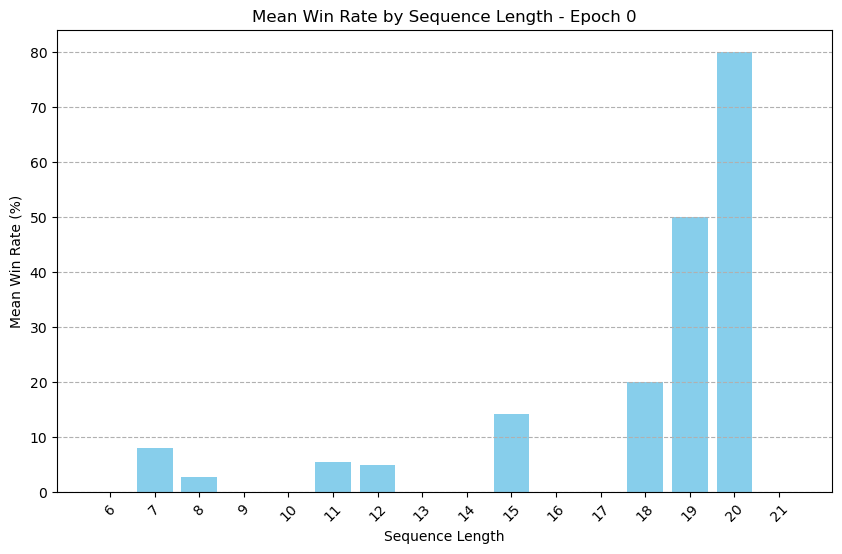

In [11]:
from pytorch_lightning.profilers import SimpleProfiler
import pytorch_lightning as pl
from scr.custom_callbacks import *
from scr.dataset import *
from scr.data_module import *
from scr.trainer_ import *

torch.cuda.empty_cache()

# # Create Callbacks
# loss_logging_callback = LossLoggingCallback()

# , SchedulerSetupCallback()] # , loss_logging_callback]
callbacks = [early_stop_callback] # , step_level_early_stopping] 
FAST_DEV_RUN = False
# # Calculate the minimum percentage of validation batches
# min_val_batches = 1 / len(data_module.val_dataloader())

# # Create Trainer with Callbacks
trainer = pl.Trainer(
    default_root_dir=output_dir,
    fast_dev_run=FAST_DEV_RUN, 
    max_epochs=MAX_EPOCH, 
    callbacks=callbacks,
    num_sanity_val_steps=0,
    # reload_dataloaders_every_n_epochs=1,
    enable_progress_bar=True 
    # val_check_interval=0.5
    # limit_train_batches=2,  # Limit the number of training batches to 2
    # limit_val_batches=2     # Limit the number of validation batches to 2
)

# # # # # print(f"Running for {NUM_STRATIFIED_SAMPLES} samples...")
# # # # print()
# # # # # # # # # # Assuming combined_eval_metrics is a list of dictionaries
combined_eval_metrics = trainer.validate(model=lightning_model, datamodule=data_module)

In [12]:
# performance_metrics_dict = {k: v for d in combined_eval_metrics for k, v in d.items()}

# # # # # # print("Converted Performance Metrics Dictb ionary:", performance_metrics_dict)

# # data_module.update_performance_metrics(performance_metrics_dict)

# performance_metrics_dict

# composite_scores = calculate_composite_scores(performance_metrics_dict)

# trainer.datamodule.update_performance_metrics(composite_scores)

##### Tuning: lr

In [13]:
# from pytorch_lightning.tuner.tuning import Tuner

# # Assuming lightning_model, train_loader, and val_loader are already defined
# # Initialize the tuner with your trainer
# tuner = Tuner(trainer)

# # Run the learning rate finder using the data module
# lr_finder = tuner.lr_find(model=lightning_model, 
#                         datamodule=data_module)

# # Plot the learning rate finder results
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # Get the suggested learning rate
# new_lr = lr_finder.suggestion()
# print(f"Suggested Learning Rate: {new_lr}")

# # Update model's learning rate
# lightning_model.learning_rate = new_lr

# # Optionally, you can view the results of the LR finder
# print(lr_finder.results)

In [14]:
# # Update model's learning rate
# lightning_model.learning_rate = 0.017378008287493765 # new_lr

##### Tuning: Batch

In [15]:
# # Assuming lightning_model is already defined
# new_batch_size = tuner.scale_batch_size(
#     model=lightning_model,
#     datamodule=data_module,
#     mode='power',  # or 'binsearch'
#     steps_per_trial=10,
#     init_val=1024,
#     # max_trials=4
# )

# Update the batch size in the data module
data_module.batch_size = 1024 # new_batch_size

# print(f"Tune Batch size: ", new_batch_size)

##### Training

In [16]:
# # # # # Validate the model (if needed)
# trainer.validate(model=lightning_model, datamodule=data_module)
print(f"Training Begin for {NUM_STRATIFIED_SAMPLES} words: {len(train_dataset)} Games")

# # # # # # Fit the model
trainer.fit(lightning_model, data_module)

# # Optionally print the profiler summary
# # print(profiler.summary())

# # Save the entire model
# trained_model_file = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
# torch.save(lightning_model, trained_model_file)
# print(f"Model saved at {trained_model_file}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoder    | 1.4 K 
1 | decoder | SimpleLSTM | 389 K 
---------------------------------------
390 K     Trainable params
0         Non-trainable params
390 K     Total params
1.562     Total estimated model params size (MB)


Training Begin for 100 words: 6916 Games


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/230 [00:00<?, ?word/s]

Metric win_rate improved. New best score: 6.087


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_0_2024-02-02_09-15-04.png


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/230 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_1_2024-02-02_09-15-16.png


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/230 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_2_2024-02-02_09-15-29.png


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/230 [00:00<?, ?word/s]

Metric win_rate improved by 1.304 >= min_delta = 0.0. New best score: 7.391


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_3_2024-02-02_09-15-42.png


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/230 [00:00<?, ?word/s]

Metric win_rate improved by 1.739 >= min_delta = 0.0. New best score: 9.130


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_4_2024-02-02_09-15-55.png


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/230 [00:00<?, ?word/s]

In [ ]:
# Save the entire model
trained_model_file = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
torch.save(lightning_model, trained_model_file)
print(f"Model saved at {trained_model_file}")

##### Testing

In [ ]:
# Load the entire LSTM model object

trained_model_file_path = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
trained_model = torch.load(trained_model_file_path)

# # # If you want to use the model for inference
# # trained_model.eval()  # Set the model to evaluation mode

# from scr.game import *

# word = 'may'

# play_game_with_a_word(trained_model, \
#     word, char_frequency, max_word_length)

In [ ]:
# Example usage
result = play_games_and_calculate_stats(trained_model, \
    sampled_test_words, char_frequency, max_word_length)

print(f"Overall Win Rate: {result['overall_win_rate']}%, Overall Average Attempts: {result['overall_avg_attempts']}")

# for length, data in result["length_wise_stats"].items():
#     print(f"Length {length}: Win Rate: {data['win_rate']}%, Average Attempts: {data['average_attempts_used']}")